## Visualizing Original Geoparser - By Years

In this case, we have used the [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix)  using the original language model for finding the Name Entities of all the books of a particular edition, and select the ones regarding with places. Later, once we have the locations entities, it uses the georesolver to resolve these locations.
                       
The query for running that we have used is the following: 

`sspark-submit --py-files defoe.zip defoe/run_queries.py nls_gaz.txt  nls -l query_distributed_topics.txt -n 16 `


And the queries/lang_model.yml specifies the spaCy language model to use:
`lang_model: original`


### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_Gazetteer/results_paper/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]    
    for i in result.keys():
        print("year %s" %i)
        t_ind = 0
        e_ind = 0
        year = i
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
            if locs != {}:
                data=[]
                l_ind = 0
                for t in locs:
                    if type(locs[t]) == type([]) :
                        c_locs=locs[t].copy()
                        c_locs.append(t.split("-")[0])
                        c_locs.append(page)
                        c_locs.append(year)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page', 'Year'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [5]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'])
        if place_name not in filter_list:
            #print(i, place_count,place_name)
            if place_name not in place_label:
                k = k + 1
            place_label.append(place_name)
            place_freq.append(place_count)
         
        i = i + 1
    return place_label, place_freq

In [52]:
def plot_bar_places_by_years(df_group_places_years,plot_type="resolved"):
    num_subplots=len(df_group_places_years.keys())
    fig, axs = plt.subplots(num_subplots,1, squeeze=False)
    plt.subplots_adjust(hspace = 0.5, top=0.95)
    fig.set_size_inches(20, 30)
    i=0
    if plot_type == "resolved":
        fig.suptitle('15 Places most mentioned using the Original Geoparser ', fontsize = 20)
    else:
        fig.suptitle('15 Places most mentioned but not resolved using the Original Geoparser', fontsize = 20)
    for y in sorted(df_group_places_years.keys()):
        df_group_places = df_group_places_years[y]
        index = np.arange(len(df_group_places['Place']))

        if plot_type == "resolved":
            axs[i,0].bar(index, df_group_places['count'], color='orange')
            axs[i,0].set_title('Year %s' %y)
        else: 
            axs[i,0].bar(index, df_group_places['count'], color='coral')
            axs[i,0].set_title('Year %s' %y)
        axs[i,0].set_xticks(index) 
        axs[i,0].set_xticklabels(list(df_group_places['Place']), rotation=20)  
        axs[i,0].set_ylabel('Frequency of Places') 
        i=i +1 

In [143]:
# Plot lines of different places
def cumulative_plot(df, list_places, list_years):
    fig = plt.figure(figsize=(12, 6))
    line_weight = 3
    alpha = .5
    tt=df_group_places_years_final.reset_index()
    years=set()
    for pl in list_places:
        freq_term={}
        for i in sorted(years_list):
            try:
                freq_term[i]= list(tt.loc[(tt['Place']==pl) & (tt['level_0']==i) ]["count"])[0]
            except:
                freq_term[i] = 0
        plt.plot(*zip(*sorted(freq_term.items())), lw=line_weight, alpha=alpha, label=pl, marker='d') 
    
    for i in sorted(years_list):
        years.add(i)
    plt.xticks(sorted(list(years)), rotation=50)  
    plt.title('Yearly cumulative plot of selected places' )
    plt.legend(loc='upper left')
    plt.ylabel('Frequency of Places')
    plt.xlabel("Years")
    plt.show()
       

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages from each directory listed in nls_gaz.txt, which each corresponds to a book of the "Scottish Gazzeter"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities*.
- From the previous entities, just selects the one about *location* and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by year, and also gets some informative metadata


As a result we get a file per book with an entry per page with the following information:

    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (original_geoparser)
    * type_distribution: type of document (newspaper|book). In this case is "book". 
    * year: Publication year 

`Example:
     
    - edition: '1828'
      georesolution_page:
       Aberdeen-rb19:
        - '57.1333333'
        - '-2.1'
       Edinburgh-rb7:
        - '55.9497284685701'
        - '-3.19333076477051'
    
      lang_model: geoparser_original
      page_filename: alto/97351031.34.xml
      text_unit id: Page27
      title: Descriptive account of the principal towns in Scotland to accompany Wood's town atlas`


### Reading the file and creating the first dataframe

In [8]:
results=read_query_results('geoparser_original_total')

In [9]:
df_total= geresolution_dataframe(results)

year 1828
year 1838
year 1883
year 1825
year 1803
year 1806
year 1901
year 1848
year 1846
year 1882
year 1868
year 1842


In [10]:
df_total.head(15)

,Latitude,Longitude,Place,Page,Year
0,55.95,-3.3725,EDINBURGH,Page7,1828
1,33.64836,-98.46944999999999,Scotland,Page9,1828
2,-18.8,29.6666667,Sir Walter Scott,Page13,1828
3,49.057976687,-122.252570429,Abbotsford,Page13,1828
4,48.199790421,-91.68354363,Bart,Page13,1828
5,37.6537254,-81.3151021,Ury,Page14,1828
6,38.2240145,-76.4616192,Hillton,Page14,1828
7,54.9833333,-3.2666667,Annan,Page17,1828
8,55.073,-3.604,Dumfries,Page17,1828
9,56.3666667,-3.8333333,Crieff,Page17,1828


### Generic Explorations 

**Important: Number of Places that has been identified!**

In [98]:
df_total[["Place"]].count()

Place    556213
dtype: int64

**Important: Going to remove City of | Contry of | County of  in the strings of Places**

In [99]:
df_total['Place'] = df_total['Place'].str.replace(r'City of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'city of ', '')

In [100]:
df_total['Place'] = df_total['Place'].str.replace(r'Country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'country of ', '')

In [101]:
df_total['Place'] = df_total['Place'].str.replace(r'County of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'county of ', '')

**Important: Number of Places that has been identified but not resolved!**

In [102]:
df_total.loc[df_total['Latitude'] == ''].count()

Latitude     65218
Longitude    65218
Place        65218
Page         65218
Year         65218
dtype: int64

**Important: Counting the total number of places identified - included the not resolved ones**

In [103]:
df_total.groupby("Year").count()

,Latitude,Longitude,Place,Page
Year,,,,
1803,12722,12722,12722,12722
1806,14415,14415,14415,14415
1825,9270,9270,9270,9270
1828,2288,2288,2288,2288
1838,30462,30462,30462,30462
1842,66091,66091,66091,66091
1846,34369,34369,34369,34369
1848,32607,32607,32607,32607
1868,80173,80173,80173,80173


**Important: Number of Places that has been identified AND  resolved!**

In [104]:
df_total.loc[df_total['Latitude'] != ''].count()

Latitude     490995
Longitude    490995
Place        490995
Page         490995
Year         490995
dtype: int64

### Explorations with georesolved places

**Important: New dataframe- df_resolved- without the rows has been resolved!!**

In [105]:
df_resolved = df_total[df_total['Latitude'] != '']

In [106]:
df_resolved.count()

Latitude     490995
Longitude    490995
Place        490995
Page         490995
Year         490995
dtype: int64

**Places names - forcing all to lower case, and later capitalize them**

In [107]:
df2 = df_resolved.copy()
df2['Place']=df_resolved['Place'].apply(str.lower)

In [108]:
df_capitalized= df2.copy()
df_capitalized['Place']=df2['Place'].apply(str.capitalize)
#Displaying the first 15 rows
df_capitalized.head(15)

,Latitude,Longitude,Place,Page,Year
0,55.95,-3.3725,Edinburgh,Page7,1828
1,33.64836,-98.46944999999999,Scotland,Page9,1828
2,-18.8,29.6666667,Sir walter scott,Page13,1828
3,49.057976687,-122.252570429,Abbotsford,Page13,1828
4,48.199790421,-91.68354363,Bart,Page13,1828
5,37.6537254,-81.3151021,Ury,Page14,1828
6,38.2240145,-76.4616192,Hillton,Page14,1828
7,54.9833333,-3.2666667,Annan,Page17,1828
8,55.073,-3.604,Dumfries,Page17,1828
9,56.3666667,-3.8333333,Crieff,Page17,1828


**Important: Calculating the number of georesolved places by year**

We have another table like this at the end of the notebook, for the places that has not been geolocated/resolved.

In [109]:
df_capitalized.groupby("Year").count()

,Latitude,Longitude,Place,Page
Year,,,,
1803,11773,11773,11773,11773
1806,13348,13348,13348,13348
1825,8569,8569,8569,8569
1828,2184,2184,2184,2184
1838,28050,28050,28050,28050
1842,61035,61035,61035,61035
1846,30669,30669,30669,30669
1848,29932,29932,29932,29932
1868,72227,72227,72227,72227


### Visualizing the 15 places more mentioned (and resolved) per year

In [110]:
mpl.rcParams['figure.dpi']=300
years_list = df_capitalized['Year'].unique()
filter_list=[]
df_group_places_years={}
for y in years_list:
    df_filter_year=df_capitalized.loc[df_capitalized['Year'] == y]
    df_max_geolocations = df_filter_year[['Latitude','Longitude','Year']].groupby(['Latitude', 'Longitude','Year'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   
    place_label, place_freq = label_freq_places(df_filter_year, df_max_geolocations, filter_list)
    df_places = {'Place':place_label,'Place_freq':place_freq}
    df_places_freq = pd.DataFrame(df_places)
    df_group_places = df_places_freq.groupby(['Place'])['Place_freq'].sum()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   
    df_group_places_years[y]=df_group_places

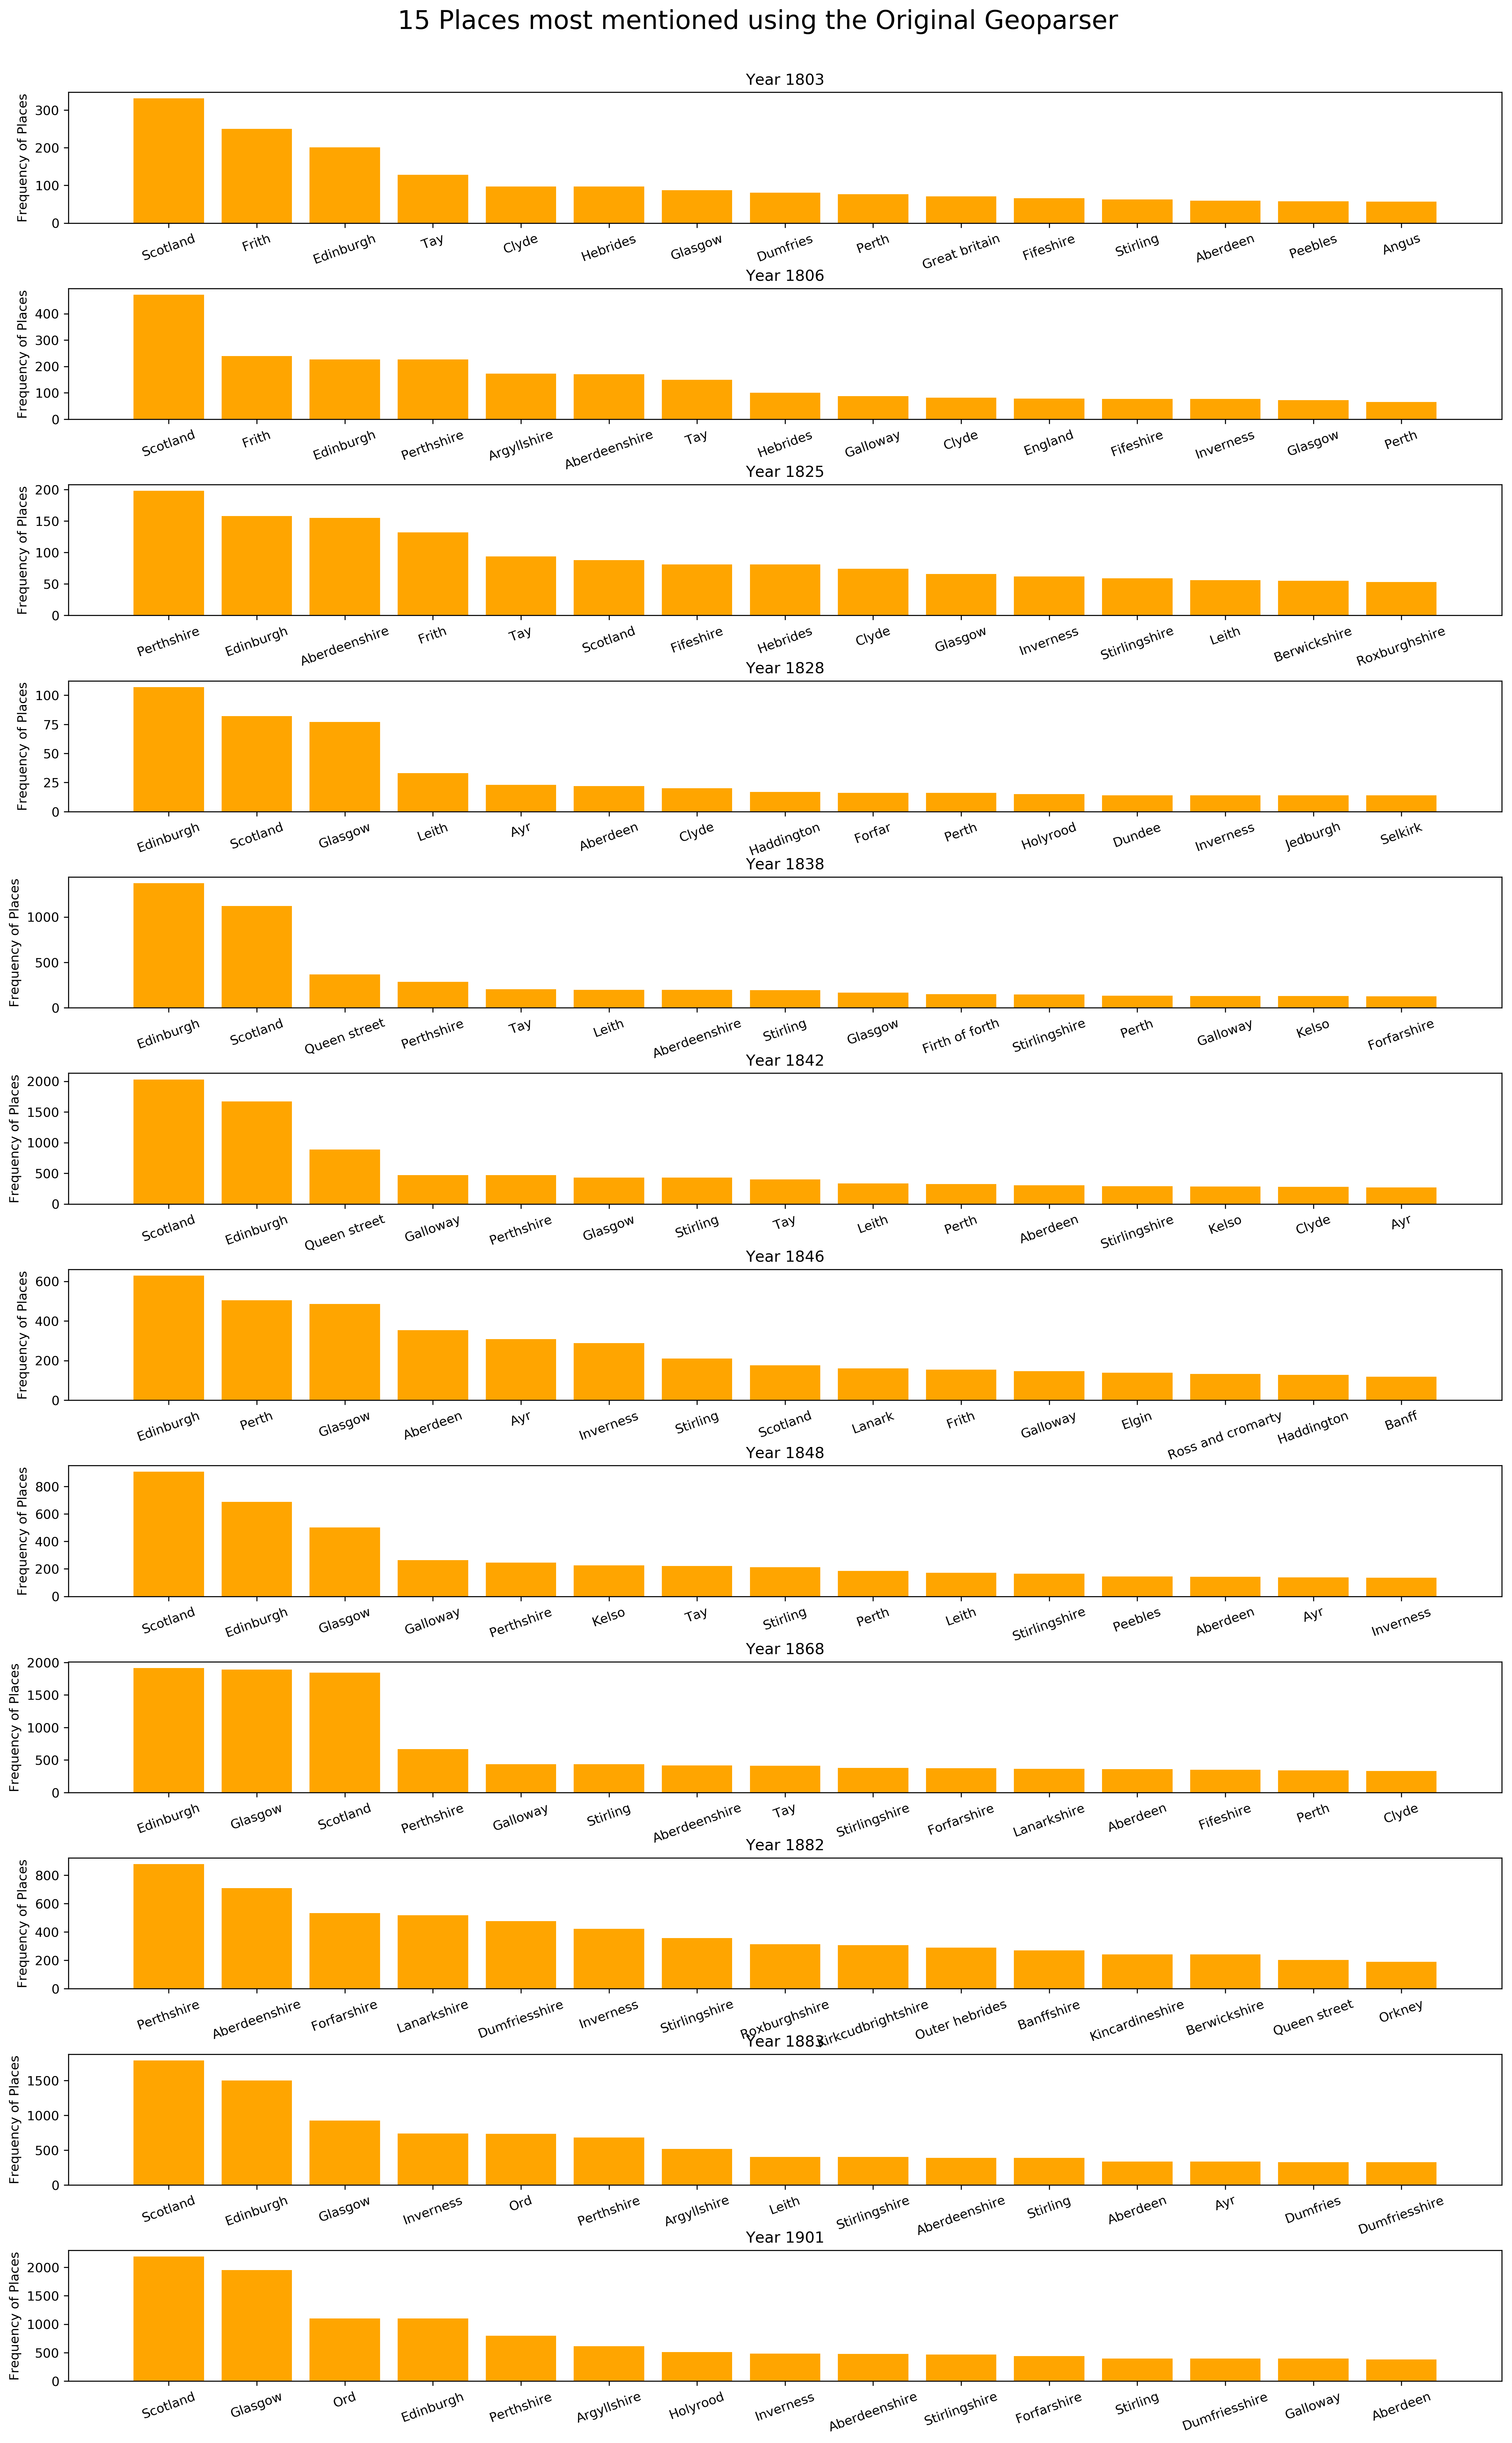

In [111]:
plot_bar_places_by_years(df_group_places_years,plot_type="resolved")

In [112]:
#As an example, we can get the number of places by years - e.g. 1828.
df_group_places_years["1828"]

,Place,count
4,Edinburgh,107
13,Scotland,82
6,Glasgow,77
11,Leith,33
1,Ayr,23
0,Aberdeen,22
2,Clyde,20
7,Haddington,17
5,Forfar,16
12,Perth,16


### Cumulative Yearly Plot 

First we have to create a new concatenated dataframe with all the information per year - Years as the index.
This new dataframe has **sub-dataframe per year with the 15 places more geolocated**. 

In [113]:
df_group_places_years_final = pd.concat(df_group_places_years)

In [114]:
#Displaying the first 10 rows
df_group_places_years_final.head(10)

Place  count
1803 12       Scotland    331
     6           Frith    250
     4       Edinburgh    201
     14            Tay    128
     2           Clyde     97
     9        Hebrides     97
     7         Glasgow     87
     3        Dumfries     81
     11          Perth     77
     8   Great britain     71

**Exploring Edinburgh over the years**

In [115]:
df_group_places_years_final.loc[df_group_places_years_final['Place']=='Edinburgh']

,,Place,count
1803,4,Edinburgh,201
1806,3,Edinburgh,227
1825,3,Edinburgh,158
1828,4,Edinburgh,107
1838,1,Edinburgh,1372
1842,3,Edinburgh,1673
1846,3,Edinburgh,629
1848,2,Edinburgh,687
1868,3,Edinburgh,1915
1883,6,Edinburgh,1499


List of the places' name that we have in this dataframe, so we can select later, which places to explore.

In [116]:
df_group_places_years_final.Place.unique()

array(['Scotland', 'Frith', 'Edinburgh', 'Tay', 'Clyde', 'Hebrides',
       'Glasgow', 'Dumfries', 'Perth', 'Great britain', 'Fifeshire',
       'Stirling', 'Aberdeen', 'Peebles', 'Angus', 'Perthshire',
       'Argyllshire', 'Aberdeenshire', 'Galloway', 'England', 'Inverness',
       'Stirlingshire', 'Leith', 'Berwickshire', 'Roxburghshire', 'Ayr',
       'Haddington', 'Forfar', 'Holyrood', 'Dundee', 'Jedburgh', 'Selkirk',
       'Queen street', 'Firth of forth', 'Kelso', 'Forfarshire', 'Lanark',
       'Elgin', 'Ross and cromarty', 'Banff', 'Lanarkshire',
       'Dumfriesshire', 'Kirkcudbrightshire', 'Outer hebrides',
       'Banffshire', 'Kincardineshire', 'Orkney', 'Ord'], dtype=object)

And finally, the cumulative plot 

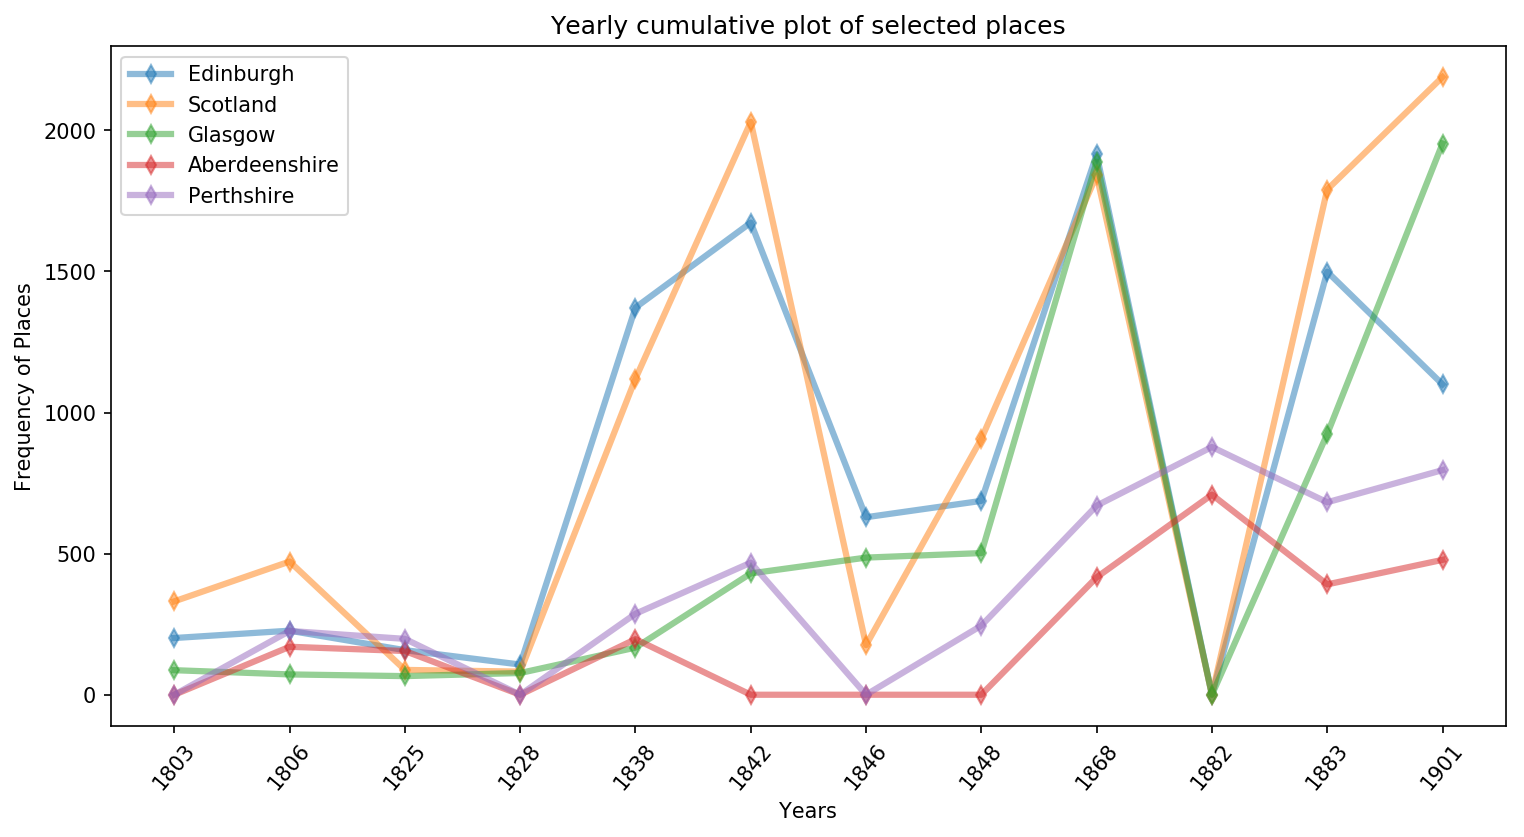

In [144]:
mpl.rcParams['figure.dpi']=150
list_places=["Edinburgh", "Scotland", "Glasgow", "Aberdeenshire", "Perthshire"]
cumulative_plot(df_group_places_years_final, list_places, sorted(years_list))

### Exploration - Not georesolved places

**Important: Calculating the number of not georesolved places by year**

In [33]:
df_not_resolved=df_total.loc[df_total['Latitude'] == '']

In [34]:
df_not_resolved.groupby("Year").count()

,Latitude,Longitude,Place,Page
Year,,,,
1803,949,949,949,949
1806,1067,1067,1067,1067
1825,701,701,701,701
1828,104,104,104,104
1838,2412,2412,2412,2412
1842,5056,5056,5056,5056
1846,3700,3700,3700,3700
1848,2675,2675,2675,2675
1868,7946,7946,7946,7946
